#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


# Implementacja rozwiązania

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

### Klasa Chromosome

In [3]:
class Chromosome:
  def __init__(self, length=4, array=None): #if array is None it should be initialized with random binary vector
    if array:
      self.array = array
    else:
      self.array = list(np.random.randint(2, size = length))
    self.length = len(self.array)


  def decode(self, lower_bound, upper_bound, aoi):
    dec = int(''.join(map(str, self.array[lower_bound : upper_bound + 1])), 2)
    max = (2**(upper_bound - lower_bound + 1)) - 1
    norm_value = min_max_norm(dec, 0, max, aoi[0], aoi[1])
    return norm_value

  def mutation(self, probability):
    if np.random.rand() < probability:
      gene = np.random.randint(0, self.length)
      self.array[gene] = 1 if self.array[gene] == 0 else 0

  def crossover(self, other):
    crossover_point = np.random.randint(self.length)
    child1_array = self.array[:crossover_point] + other.array[crossover_point:]
    child2_array = other.array[:crossover_point] + self.array[crossover_point:]
    child1 = Chromosome(array=child1_array)
    child2 = Chromosome(array=child2_array)
    return child1, child2

### Algorytm Genetyczny

In [53]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_length = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps

    self.population = []
    for i in range(population_size):
      self.population.append(Chromosome(length=chromosome_length))


  def decode_to_args(self, chromosome):
    fun_args = []
    for i in range(0, self.chromosome_length, self.chromosome_length // self.obj_func_num_args):
      fun_args.append(chromosome.decode(i, i + self.chromosome_length // self.obj_func_num_args - 1, self.aoi))
    return fun_args


  def eval_objective_func(self, chromosome):
    fun_args = self.decode_to_args(chromosome)
    return self.objective_function(*fun_args)


  def tournament_selection(self):
    selected_population = []
    for individual in self.population:
      selected = []
      selected.append(individual)
      selected.extend(random.sample(self.population, self.tournament_size-1))
      best = min(selected, key = lambda x: self.eval_objective_func(x))
      selected_population.append(best)
    return selected_population


  def reproduce(self):
    selected_population = self.tournament_selection()
    new_population = []

    for parent1 in selected_population:
        parent2 = random.choice(selected_population)
        if np.random.rand() < self.crossover_probability:
          child1, child2 = parent1.crossover(parent2)
          child1.mutation(self.mutation_probability)
          child2.mutation(self.mutation_probability)
          best_child = min(child1, child2, key = lambda x: self.eval_objective_func(x))
          new_population.append(best_child)
        else:
          new_population.append(parent1)

    self.population = new_population[:len(self.population)]


  def run(self, verbose:int=0, plot:bool=False):
    trace = []
    for step in range(self.num_steps):
      self.reproduce()
      best = min(self.population, key = lambda x: self.eval_objective_func(x))
      fun_args = self.decode_to_args(best)

      trace.append(fun_args)

      if verbose > 0:
        print(f'Step {step}, best_args={fun_args}, f(x)={self.eval_objective_func(best)}')

    if plot:
      self.plot_func(trace)

    return min(self.population, key = lambda x: self.eval_objective_func(x))


  def plot_func(self, trace):
    X = np.arange(-3, 3, 0.05)
    Y = np.arange(-3, 3, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

## Użycie algorytmu genetycznego do znalezienia minimum funkcji g(x)
Na wykresie widać punkty, które były najlepsze w swoim pokoleniu

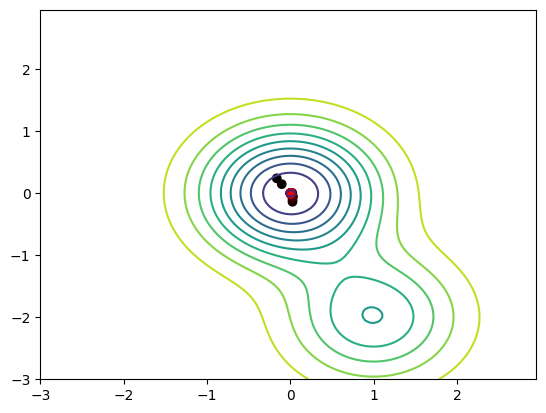

Best x1=0.003524834058136861, x2=-0.007003891050583633, f(x1,x2)=0.4965724886051915


In [55]:
def g(x1, x2):
  return 1.5-np.exp(-x1**(2)-x2**(2))-0.5*np.exp(-(x1-1)**(2)-(x2+2)**(2))

genetic = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=g, aoi=[-3,3], population_size=100, tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30)
best_chromosome = genetic.run(plot=True)
best_x1, best_x2 = genetic.decode_to_args(best_chromosome)
print(f'Best x1={best_x1}, x2={best_x2}, f(x1,x2)={genetic.eval_objective_func(best_chromosome)}')

# Wpływ parametrów algorytmy genetycznego na wyniki
**Ilośc genów w chromosomie**\
Jak widać na wykresach, zbyt mała ilość genów w chromosomie zmniejsza dokładność argumentów, które reprezentuje ten chrommosom, dochodzi do sytuacji, gdzie niemożliwe jest trafienie w odpowiednie rozwiązanie

chromosome_length=4


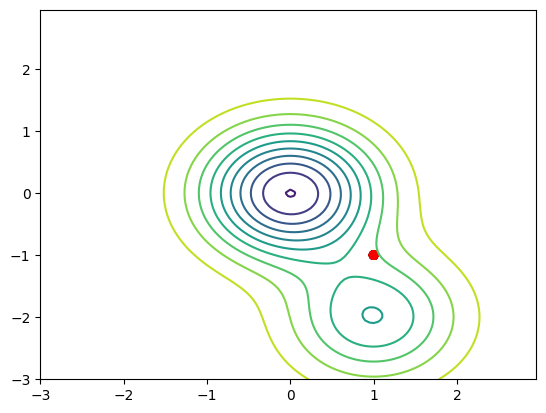

chromosome_length=8


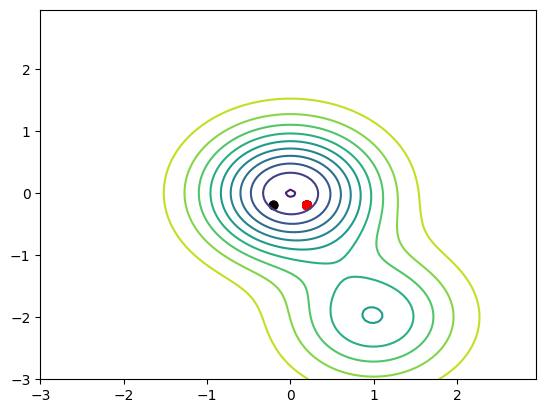

chromosome_length=32


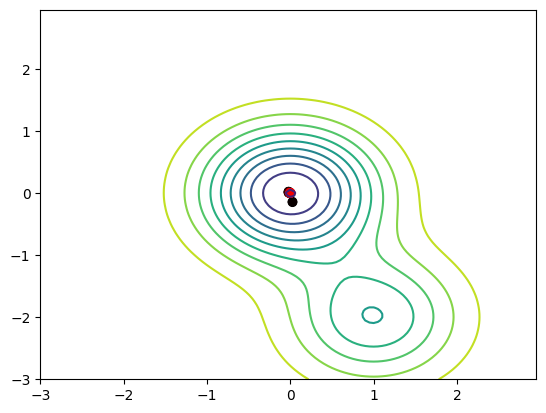

In [56]:
for length in [4, 8, 32]:
  print(f'chromosome_length={length}')
  genetic = GeneticAlgorithm(chromosome_length=length, obj_func_num_args=2, objective_function=g, aoi=[-3,3], population_size=100, tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30)
  genetic.run(plot=True)


**Wielkość populacji** \
Przy zbyt małej populacji, różnorodność genów może być zbyt mała, żeby osiągnąć najbardziej optymalne rozwiązanie. Algorytm może utknąć w innym mniej korzystnym minimum funckji. Przy dużej populacji istnieje większe prawdopodobieństwo, że już na etapie generowania losowych genów, pojawi się rozwiązanie bliskie idealnemu.

population_size=10


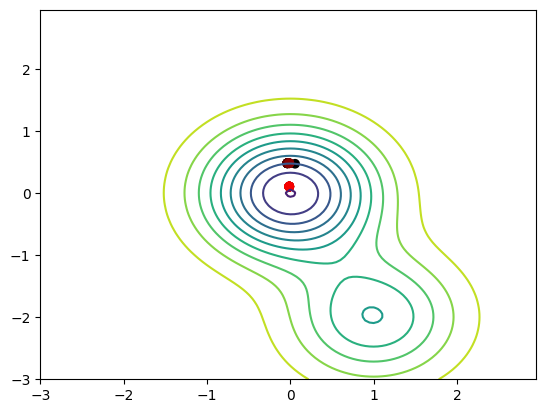

population_size=100


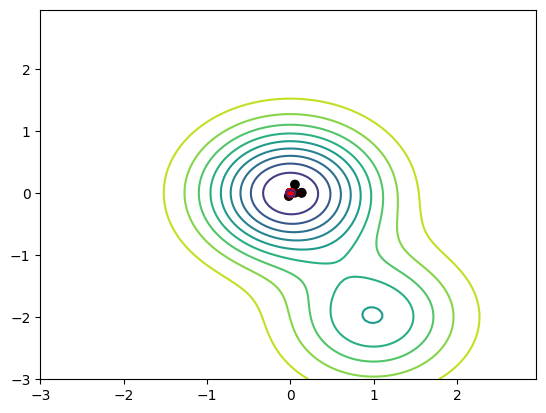

population_size=1000


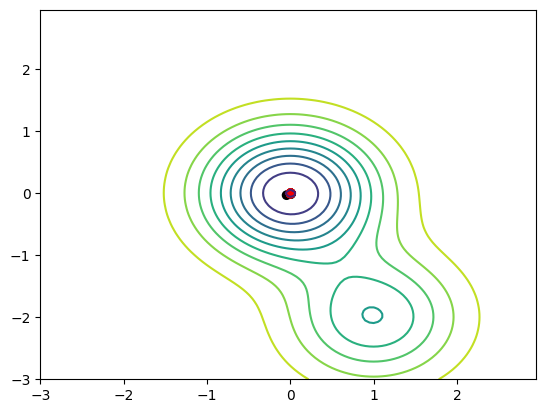

In [57]:
for size in [10, 100, 1000]:
  print(f'population_size={size}')
  genetic = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=g, aoi=[-3,3], population_size=size, tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30)
  genetic.run(plot=True)

**Wielkość grupy w selekcji turniejowej** \
Tworzenie większych grup turniejowych powoduje szybsze stworzenie optymalnego rozwiązania, ponieważ wybieramy tylko najlepsze osobniki. Zmniejszenie grup tworzy bardziej zróżnicowaną populację, co jest istotne w poszukiwaniu globalnych rozwiązań. Dodatkowo mniejsze grupy wymagają mniej obliczeń.


tournament_size=2


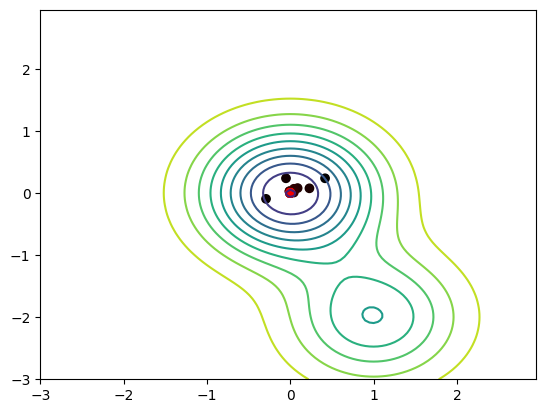

tournament_size=5


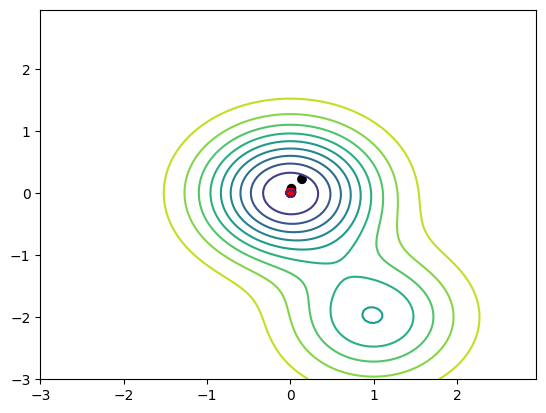

tournament_size=10


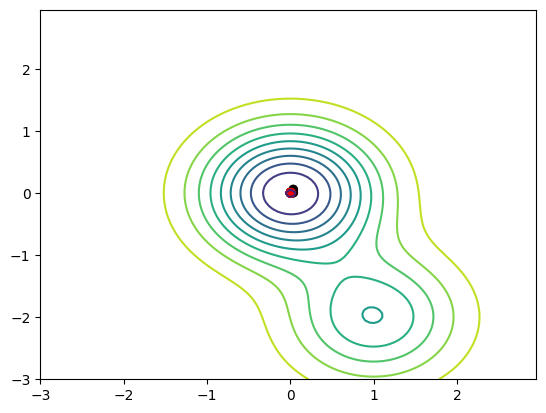

In [58]:
for size in [2, 5, 10]:
  print(f'tournament_size={size}')
  genetic = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=g, aoi=[-3,3], population_size=100, tournament_size=size, mutation_probability=0.05, crossover_probability=0.8, num_steps=30)
  genetic.run(plot=True)

**Prawdopodobieństwo mutacji** \
Brak mutacji, może spowodować, że z wylosowanej populacji nie będzie możliwości stworzenia optymalnego rozwiązania. Mutacje pomagają uniknąć zatrzymania w nieoptymalnym minimum  i prowadzi do większej różnorodności genotypów w populacji. Zbyt duże prawdopodobieństwo mutacji powoduje chaotyczne zachowanie się algorytmu.

mutation_probability=0


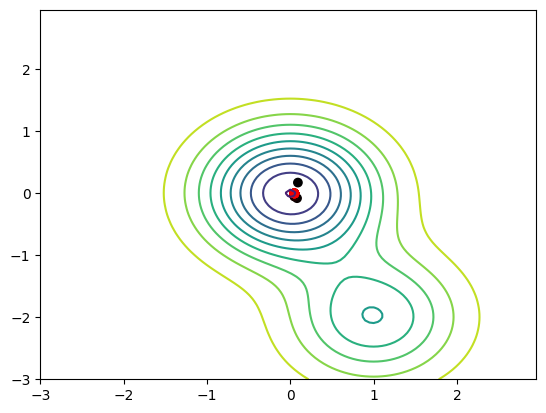

mutation_probability=0.05


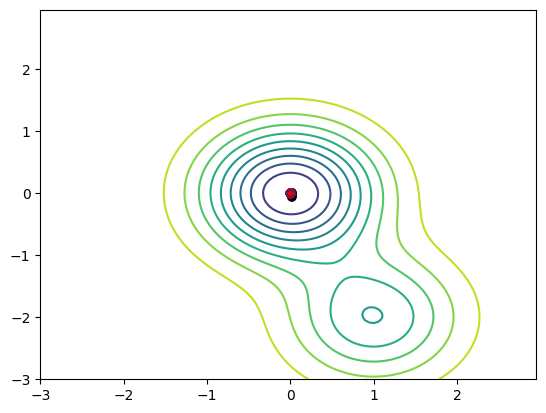

mutation_probability=0.5


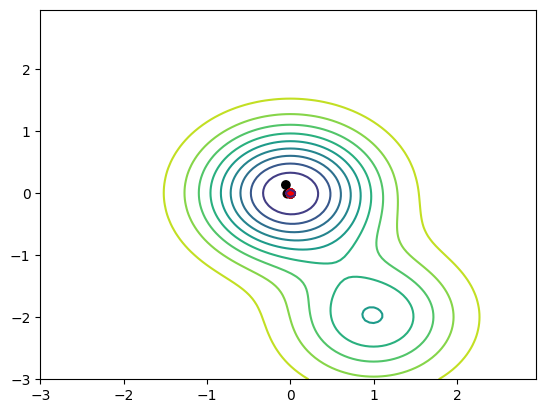

In [62]:
for probability in [0, 0.05, 0.5]:
  print(f'mutation_probability={probability}')
  genetic = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=g, aoi=[-3,3], population_size=100, tournament_size=2, mutation_probability=probability, crossover_probability=0.8, num_steps=30)
  genetic.run(plot=True)

**Prawdopodobieństwo krzyzowania jednopunktowego** \
Wieksze prawdopodobieństwo krzyżowania powoduję większą różnorodność w potomnej populacji

crossover_probability=0.2


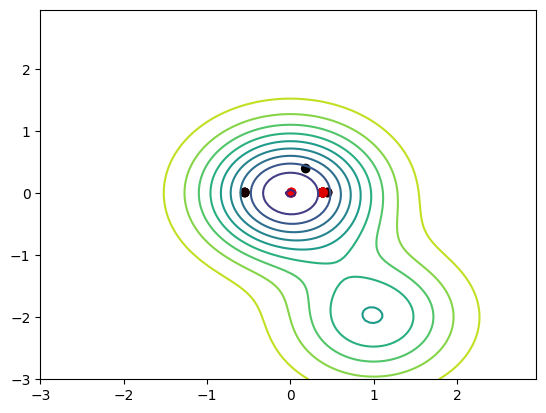

crossover_probability=0.5


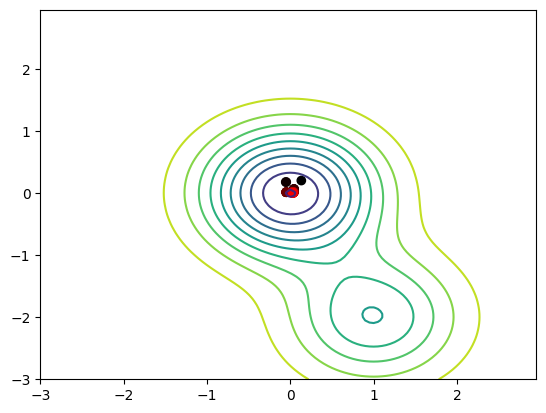

crossover_probability=0.8


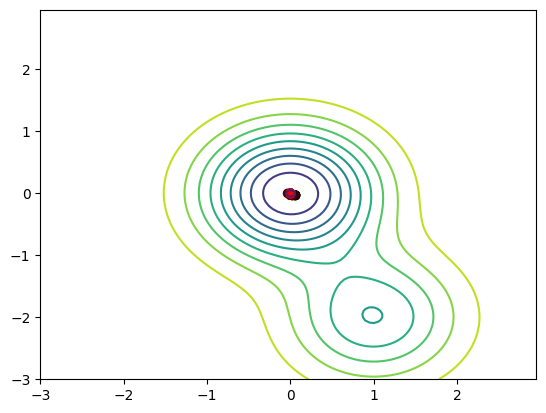

In [ ]:
for probability in [0.2, 0.5, 0.8]:
  print(f'crossover_probability={probability}')
  genetic = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=g, aoi=[-3,3], population_size=100, tournament_size=2, mutation_probability=0.05, crossover_probability=probability, num_steps=30)
  genetic.run(plot=True)

**Ilość pokoleń** \
Zbyt mała ilość pokoleń może spowodować, że algorytm nie zdąży wyewoluować do optymalnego rozwiązania. Zbyt duża ilość pokoleń powoduje duże obciążenia obliczeniowe, ale może spowodować większą różnorodność genotypów z powodu mutacji

num_steps=5


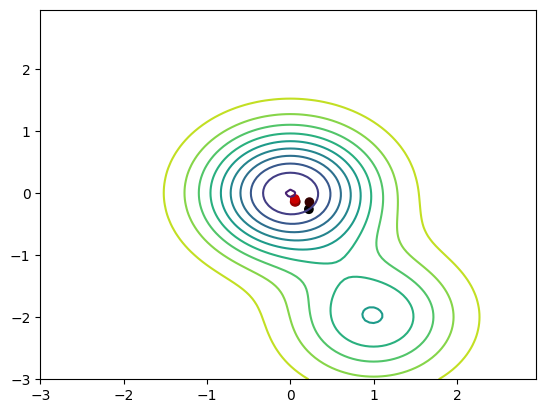

num_steps=20


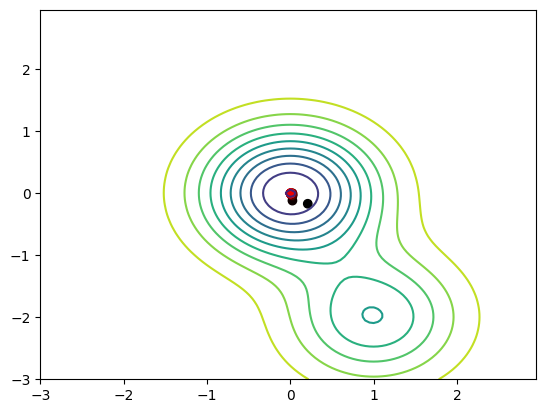

num_steps=100


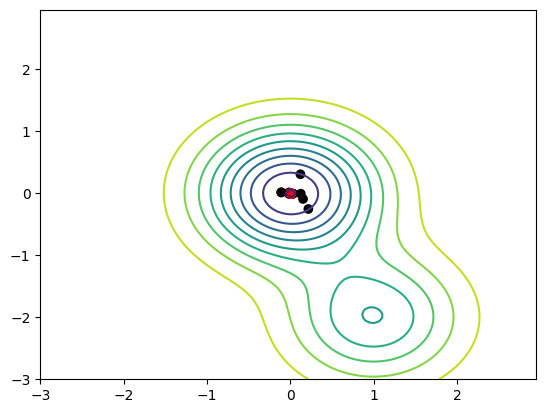

In [65]:
for num in [5, 20, 100]:
  print(f'num_steps={num}')
  genetic = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=g, aoi=[-3,3], population_size=100, tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=num)
  genetic.run(plot=True)